# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./data/train.p"
validation_file="./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
# Mapping ClassID to traffic sign names
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

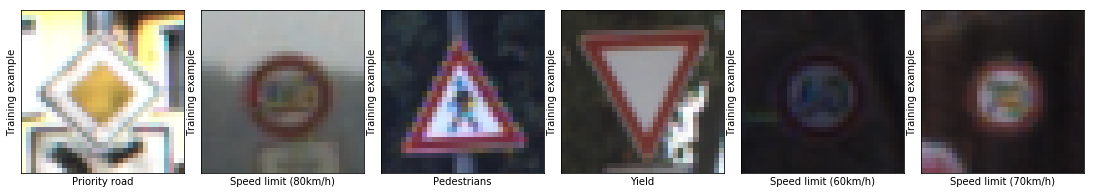

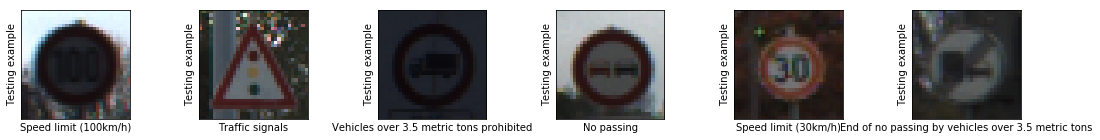

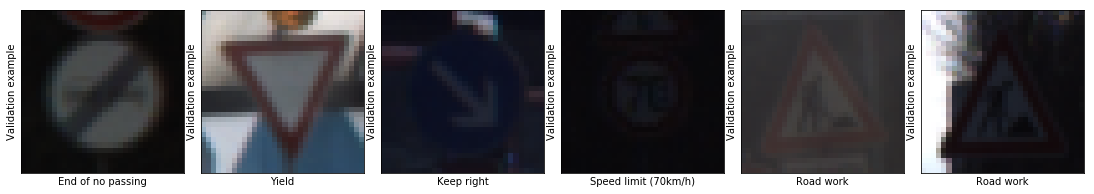

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
# Plotting sample examples
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")


In [5]:
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

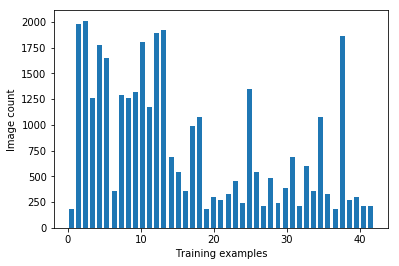

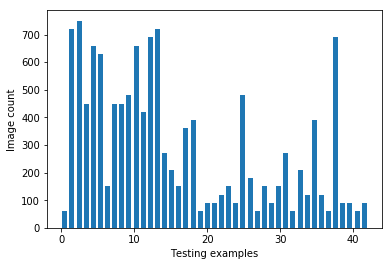

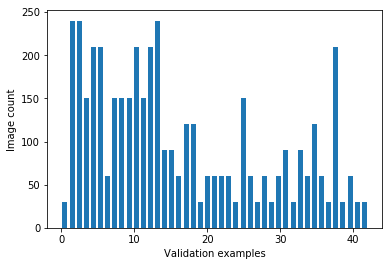

In [6]:
# Plotting histograms of the count of each sign
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.


In [7]:
X_train, y_train = shuffle(X_train, y_train)

In [8]:

def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

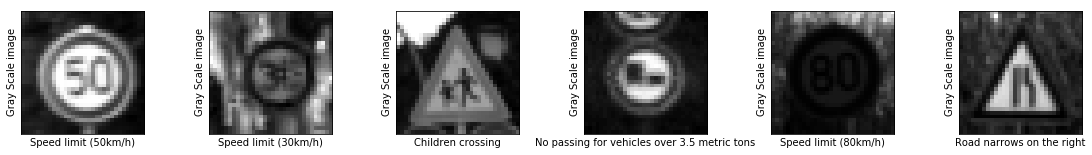

In [9]:
# Sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

In [10]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

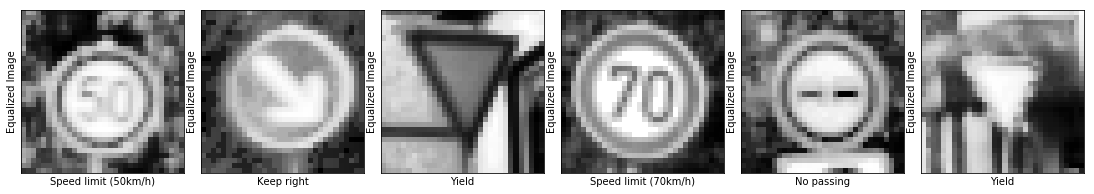

In [11]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

In [12]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

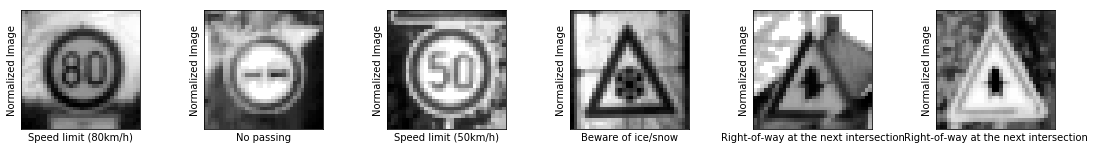

In [13]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [14]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

### Model Architecture

In [15]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
class LaNet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 28x28x6.
        self.filter1_width = 5
        self.filter1_height = 5
        self.input1_channels = 1
        self.conv1_output = 6
        # Weight and bias
        self.conv1_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # Apply Convolution
        self.conv1 = tf.nn.conv2d(x, self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias
        
        # Activation:
        self.conv1 = tf.nn.relu(self.conv1)
        
        # Pooling: Input = 28x28x6. Output = 14x14x6.
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Layer 2 (Convolutional): Output = 10x10x16.
        self.filter2_width = 5
        self.filter2_height = 5
        self.input2_channels = 6
        self.conv2_output = 16
        # Weight and bias
        self.conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # Apply Convolution
        self.conv2 = tf.nn.conv2d(self.conv1, self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias
        
        # Activation:
        self.conv2 = tf.nn.relu(self.conv2)
        
        # Pooling: Input = 10x10x16. Output = 5x5x16.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Flattening: Input = 5x5x16. Output = 400.
        self.fully_connected0 = flatten(self.conv2)
        
        # Layer 3 (Fully Connected): Input = 400. Output = 120.
        self.connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)
        
        # Activation:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)
    
        # Layer 4 (Fully Connected): Input = 120. Output = 84.
        self.connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)
        
        # Activation.
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)
    
        # Layer 5 (Fully Connected): Input = 84. Output = 43.
        self.output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits =  tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

In [16]:
class VGGnet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2 (Convolutional): Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Layer 3 (Pooling): Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)

        # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)

        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 11 (Fully Connected): Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 12 (Fully Connected): Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

In [18]:
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

In [19]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)

In [20]:
EPOCHS = 30
BATCH_SIZE = 64
DIR = 'Saved_Models'

In [21]:
tf.__version__

'1.3.0'

In [22]:
LeNet_Model = LaNet(n_out = n_classes)
model_name = "LeNet"

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training ...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(LeNet_Model.training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})
            
        validation_accuracy = LeNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    LeNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Training ...

EPOCH 1 : Validation Accuracy = 81.791%
EPOCH 2 : Validation Accuracy = 86.553%
EPOCH 3 : Validation Accuracy = 90.159%
EPOCH 4 : Validation Accuracy = 89.751%
EPOCH 5 : Validation Accuracy = 89.116%
EPOCH 6 : Validation Accuracy = 91.315%
EPOCH 7 : Validation Accuracy = 91.134%
EPOCH 8 : Validation Accuracy = 92.222%
EPOCH 9 : Validation Accuracy = 91.950%
EPOCH 10 : Validation Accuracy = 92.721%
EPOCH 11 : Validation Accuracy = 93.061%
EPOCH 12 : Validation Accuracy = 92.336%
EPOCH 13 : Validation Accuracy = 92.993%
EPOCH 14 : Validation Accuracy = 92.517%
EPOCH 15 : Validation Accuracy = 91.905%
EPOCH 16 : Validation Accuracy = 92.880%
EPOCH 17 : Validation Accuracy = 93.129%
EPOCH 18 : Validation Accuracy = 93.107%
EPOCH 19 : Validation Accuracy = 93.537%
EPOCH 20 : Validation Accuracy = 93.628%
EPOCH 21 : Validation Accuracy = 92.698%
EPOCH 22 : Validation Accuracy = 93.379%
EPOCH 23 : Validation Accuracy = 92.177%
EPOCH 24 : Validation Accuracy = 92.426%
EPOCH 25 : 

In [23]:
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Training...

EPOCH 1 : Validation Accuracy = 26.576%
EPOCH 2 : Validation Accuracy = 57.324%
EPOCH 3 : Validation Accuracy = 79.728%
EPOCH 4 : Validation Accuracy = 88.390%
EPOCH 5 : Validation Accuracy = 90.612%
EPOCH 6 : Validation Accuracy = 91.179%
EPOCH 7 : Validation Accuracy = 94.218%
EPOCH 8 : Validation Accuracy = 97.415%
EPOCH 9 : Validation Accuracy = 97.460%
EPOCH 10 : Validation Accuracy = 98.095%
EPOCH 11 : Validation Accuracy = 98.345%
EPOCH 12 : Validation Accuracy = 98.594%
EPOCH 13 : Validation Accuracy = 98.617%
EPOCH 14 : Validation Accuracy = 98.118%
EPOCH 15 : Validation Accuracy = 98.458%
EPOCH 16 : Validation Accuracy = 99.184%
EPOCH 17 : Validation Accuracy = 99.161%
EPOCH 18 : Validation Accuracy = 99.161%
EPOCH 19 : Validation Accuracy = 98.753%
EPOCH 20 : Validation Accuracy = 98.322%
EPOCH 21 : Validation Accuracy = 98.685%
EPOCH 22 : Validation Accuracy = 99.070%
EPOCH 23 : Validation Accuracy = 99.070%
EPOCH 24 : Validation Accuracy = 98.322%
EPOCH 25 : V

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [25]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.


NameError: name 'ls' is not defined

In [27]:
ls  Saved_Models/


checkpoint                 LeNet.index  VGGNet.data-00000-of-00001  VGGNet.meta
LeNet.data-00000-of-00001  LeNet.meta   VGGNet.index


In [24]:
# Test set preprocessing
X_test_preprocessed = preprocess(X_test)

In [28]:
with tf.Session() as sess:
    LeNet_Model.saver.restore(sess, os.path.join(DIR, "LeNet"))
    y_pred = LeNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from Saved_Models/LeNet
Test Accuracy = 90.8%


In [29]:
with tf.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
Test Accuracy = 97.4%


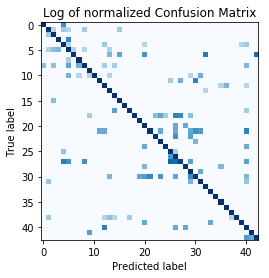

In [30]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
# Loading and resizing new test images
new_test_images = []
path = './traffic-signs-data/new_test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17]
print("Number of new testing examples: ", len(new_test_images))

Number of new testing examples:  5


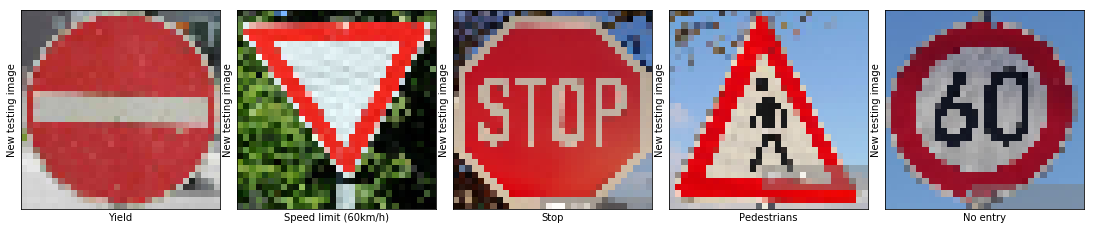

In [32]:
plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

In [33]:
# New test data preprocessing
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
New Images Test Accuracy = 40.0%


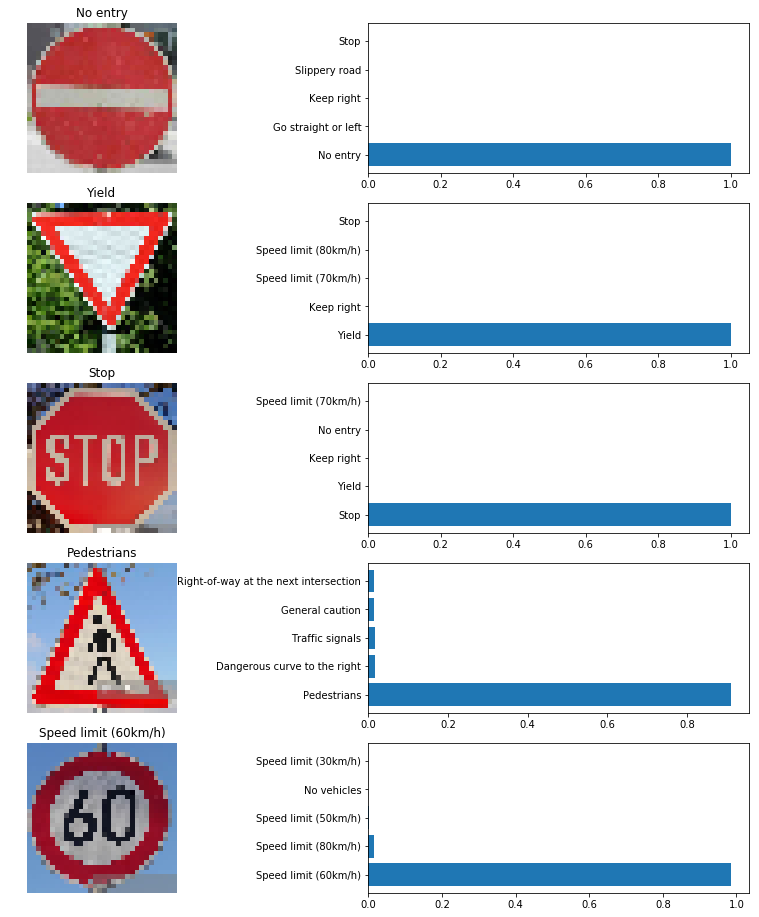

In [35]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(15, 16))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")